In [1]:
!pip install 'u8darts[torch]'

## NG Price Prediction with a TCN (Temporal Convolutional Network)


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Import the Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

## Data Plot

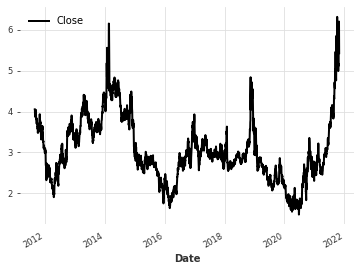

In [5]:
filepath = '../data/HistoricalData_NG.csv'

ts_close = fill_missing_values(
    TimeSeries.from_csv(filepath, time_col='Date', value_cols='Close', freq='D'), 'auto')
ts_open = fill_missing_values(
    TimeSeries.from_csv(filepath, time_col='Date', value_cols='Open', freq='D'), 'auto')
ts_high = fill_missing_values(
    TimeSeries.from_csv(filepath, time_col='Date', value_cols='High', freq='D'), 'auto')
ts_low = fill_missing_values(
    TimeSeries.from_csv(filepath, time_col='Date', value_cols='Low', freq='D'), 'auto')
ts_volume = fill_missing_values(
    TimeSeries.from_csv(filepath, time_col='Date', value_cols='Volume', freq='D'), 'auto')

ts_close.plot()

## Preprocess the data

In [6]:
from darts.dataprocessing.transformers import Scaler 
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = Scaler()
ts_transformed_close = scaler.fit_transform(ts_close)
ts_transformed_low = scaler.fit_transform(ts_low)
ts_transformed_open = scaler.fit_transform(ts_open)
ts_transformed_high = scaler.fit_transform(ts_high)

month_series = datetime_attribute_timeseries(ts_transformed_close, attribute='month', one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

train, val = ts_transformed_close.split_after(pd.Timestamp('20200101'))
train_l, val_l = ts_transformed_low.split_after(pd.Timestamp('20200101'))
train_o, val_o = ts_transformed_open.split_after(pd.Timestamp('20200101'))
train_h, val_h = ts_transformed_high.split_after(pd.Timestamp('20200101'))
train_month, val_month = month_series.split_after(pd.Timestamp('20200101'))

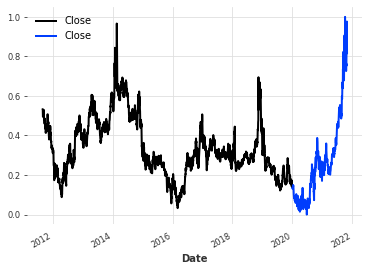

In [7]:
train.plot()
val.plot()

## Model

In [8]:
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

model = TCNModel(
    n_epochs=50, 
    input_chunk_length=63,
    output_chunk_length=7, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0,
    likelihood=GaussianLikelihood()
)

[2021-11-01 15:09:09,126] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-11-01 15:09:09,128] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


## Train the Model

In [9]:
model.fit(
    series=[train, train_o],
    past_covariates=[train_h, train_l],
    verbose=True
)

[2021-11-01 15:09:09,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5954 samples.
[2021-11-01 15:09:09,439] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 5954 samples.
[2021-11-01 15:09:09,450] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-11-01 15:09:09,450] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-11-01 15:09:09,465] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-01 15:09:09,465] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
  2%|▏         | 1/50 [00:05<04:18,  5.28s/it]

  4%|▍         | 2/50 [00:10<04:12,  5.27s/it]

  6%|▌         | 3/50 [00:15<04:08,  5.28s/it]

  8%|▊         | 4/50 [00:21<04:01,  5.25s/it]

 10%|█         | 5/50 [00:26<03:55,  5.23s/it]

 12%|█▏        | 6/50 [00:31<03:48,  5.19s/it]

 14%|█▍        | 7/50 [00:36<03:43,  5.19s/it]

 16%|█▌        | 8/50 [00:41<03:39,  5.22s/it]

 18%|█▊        | 9/50 [00:47<03:33,  5.22s/it]

 20%|██        | 10/50 [00:52<03:30,  5.26s/it]

 22%|██▏       | 11/50 [00:57<03:24,  5.24s/it]

 24%|██▍       | 12/50 [01:02<03:19,  5.25s/it]

 26%|██▌       | 13/50 [01:08<03:13,  5.24s/it]

 28%|██▊       | 14/50 [01:13<03:08,  5.24s/it]

 30%|███       | 15/50 [01:18<03:03,  5.24s/it]

 32%|███▏      | 16/50 [01:23<02:58,  5.24s/it]

 34%|███▍      | 17/50 [01:28<02:52,  5.22s/it]

 36%|███▌      | 18/50 [01:34<02:47,  5.23s/it]

 38%|███▊      | 19/50 [01:39<02:42,  5.24s/it]

 40%|████      | 20/50 [01:44<02:37,  5.25s/it]

 42%|████▏     | 21/50 [01:50<02:32,  5.27s/it]

 44%|████▍     | 22/50 [01:55<02:27,  5.28s/it]

 46%|████▌     | 23/50 [02:00<02:21,  5.26s/it]

 48%|████▊     | 24/50 [02:05<02:17,  5.28s/it]

 50%|█████     | 25/50 [02:11<02:11,  5.27s/it]

 52%|█████▏    | 26/50 [02:16<02:06,  5.28s/it]

 54%|█████▍    | 27/50 [02:21<02:00,  5.26s/it]

 56%|█████▌    | 28/50 [02:26<01:55,  5.26s/it]

 58%|█████▊    | 29/50 [02:32<01:50,  5.25s/it]

 60%|██████    | 30/50 [02:37<01:45,  5.26s/it]

 62%|██████▏   | 31/50 [02:42<01:39,  5.24s/it]

 64%|██████▍   | 32/50 [02:47<01:34,  5.24s/it]

 66%|██████▌   | 33/50 [02:53<01:29,  5.24s/it]

 68%|██████▊   | 34/50 [02:58<01:24,  5.25s/it]

 70%|███████   | 35/50 [03:03<01:19,  5.29s/it]

 72%|███████▏  | 36/50 [03:09<01:14,  5.29s/it]

 74%|███████▍  | 37/50 [03:14<01:08,  5.30s/it]

 76%|███████▌  | 38/50 [03:19<01:03,  5.31s/it]

 78%|███████▊  | 39/50 [03:25<00:58,  5.31s/it]

 80%|████████  | 40/50 [03:30<00:52,  5.29s/it]

 82%|████████▏ | 41/50 [03:35<00:47,  5.27s/it]

 84%|████████▍ | 42/50 [03:40<00:42,  5.26s/it]

 86%|████████▌ | 43/50 [03:46<00:36,  5.27s/it]

 88%|████████▊ | 44/50 [03:51<00:31,  5.27s/it]

 90%|█████████ | 45/50 [03:56<00:26,  5.27s/it]

 92%|█████████▏| 46/50 [04:01<00:21,  5.28s/it]

 94%|█████████▍| 47/50 [04:07<00:15,  5.28s/it]

 96%|█████████▌| 48/50 [04:12<00:10,  5.28s/it]

 98%|█████████▊| 49/50 [04:17<00:05,  5.30s/it]

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]

In [15]:
pred_series = model.historical_forecasts(
    series=ts_transformed_close,
    start=pd.Timestamp('20200101'), 
    past_covariates=ts_transformed_low,
    forecast_horizon=5,
    stride=2,
    retrain=False,
    verbose=True,
    num_samples=50
)

100%|██████████| 332/332 [00:06<00:00, 51.40it/s]


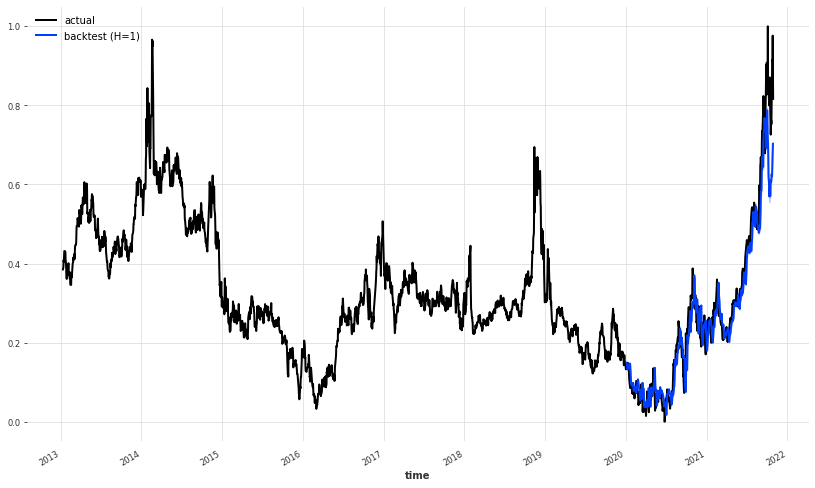

In [16]:
plt.figure(figsize=(14,8))

ts_transformed_close[500:].plot(label='actual')
pred_series.plot(label='backtest (H=1)', 
                 low_quantile=0.01,
                high_quantile=0.99)
plt.legend();

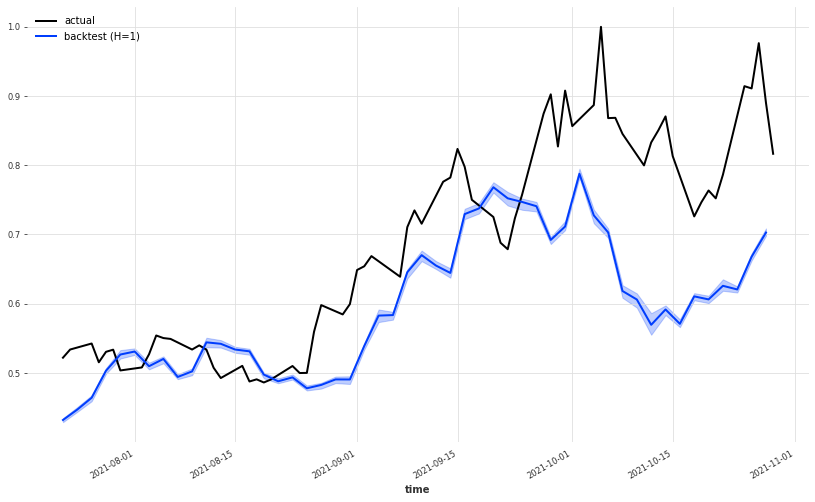

In [17]:
plt.figure(figsize=(14,8))

ts_transformed_close[-100:].plot(label='actual')
pred_series[-50:].plot(label='backtest (H=1)', 
                 low_quantile=0.01,
                high_quantile=0.99)
plt.legend();

In [18]:
pred_series = model.predict(
    n=7,
    series=ts_transformed_close,
    past_covariates=ts_transformed_open
)

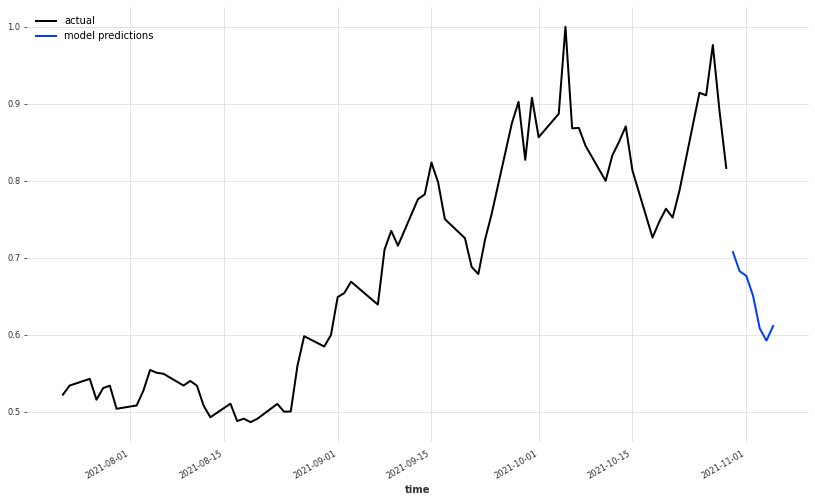

In [19]:
plt.figure(figsize=(14,8))

ts_transformed_close[-100:].plot(label='actual')
pred_series.plot(label='model predictions', 
                 low_quantile=0.01,
                high_quantile=0.99)
plt.legend();